In [1]:
import os
import sys

In [2]:
# Detect if running in Google Colab environment.
# If so, then clone/install SmartStockRL package from GitHub.
# Otherwise, use locally.
try:
    import google.colab
    IN_COLAB = True
    print('IN COLAB')

    # Clone or update repo.
    repo = "smart-stock-rl"
    repo_url = f"https://github.com/zanderman/{repo}.git"
    repo_path = f"/content/{repo}"
    repo_branch = "develop"
    ![ -d $repo_path ] && git -C $repo_path pull || git clone --branch $repo_branch $repo_url
    # !git clone --branch $repo_branch $repo_url

    # Install repo to ensure dependencies are resolved.
    !pip install --upgrade $repo_path

    # Add package location to path.
    sys.path.insert(0, repo_path)

    # Set dataset root path.
    dataset_root = '~/dataset'

except:
    IN_COLAB = False
    dataset_root = '~/Desktop'
    print('NOT IN COLAB')

# Import package.
import smart_stock as ss

IN COLAB
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/zanderman/smart-stock-rl
   f8952e6..c943d18  develop    -> origin/develop
Updating f8952e6..c943d18
Fast-forward
 jupyter/experiments_qsfm.ipynb | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)
Processing ./smart-stock-rl
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata

In [3]:
# Install future annotations for <3.7
if sys.version_info < (3,7):
    !pip install future-annotations

In [4]:
# Import other necessary packages after we know that imports are available.
from __future__ import annotations
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch

## Dataset

In [5]:
# Request user for Kaggle login if JSON file does not exist.
if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")) and os.environ.get("KAGGLE_USERNAME",None) is None and os.environ.get("KAGGLE_USERNAME",None) is None:
    import json
    import getpass
    entry = getpass.getpass(prompt="Kaggle Username or JSON blob: ")
    try:
        blob = json.loads(entry)
        os.environ["KAGGLE_USERNAME"] = blob['username']
        os.environ["KAGGLE_KEY"] = blob['key']
    except:    
        api_key = getpass.getpass(prompt="Kaggle API KEY: ")
        os.environ["KAGGLE_USERNAME"] = entry
        os.environ["KAGGLE_KEY"] = api_key

    # In Google Colab preserve the login auth across environment restarts.
    if IN_COLAB:
        with open(os.path.expanduser("~/.kaggle/kaggle.json"), 'w') as f:
            json.dump({'username':os.environ["KAGGLE_USERNAME"], 'key':os.environ["KAGGLE_KEY"]}, f)

In [6]:
# Prepare dataset.
stocks = ['aapl', 'nvda', 'dis', 'ko', 'pg']
path = os.path.expanduser(dataset_root)

# This command will download the dataset if it does not exist on the system.
dataset = ss.datasets.HugeStockMarketDataset(path, quiet=False)

## Training Functions

In [7]:
import time
from contextlib import contextmanager

class timecontext:
    """Elapsed time context manager."""
    def __enter__(self):
        self.seconds = time.time()
        return self
    
    def __exit__(self, type, value, traceback):
        self.seconds = time.time() - self.seconds

@contextmanager
def timecontextprint(description='Elapsed time'):
    """Context manager to print elapsed time from call."""
    with timecontext() as t:
        yield t
    print(f"{description}: {t.seconds} seconds")

In [8]:
def train(
    agent,
    max_episodes: int = 1000,
    **kwargs,
    ) -> tuple[list[float], bool]:
    """Generic agent training method.

    Specific methods should wrap this one and pass agent-specific arguments
    as keyword arguments.
    """
    # List of reward values for plotting.
    rewards = []

    # Boolean solution flag.
    found_soln = False

    # Episode loop.
    for i in range(max_episodes):
        reward = agent.run_episode(**kwargs)
        rewards.append(reward)
        # if i%100 == 0: print(f'[{i}] {reward}')
        print(f'[{i}] {reward}')

    return rewards, found_soln

In [9]:
def train_QSFM(
    agent: ss.algorithms.qlearning.qsfm.QSFM, 
    max_episodes: int = 1000,
    max_steps: int = None,
    render: bool = False,
    render_mode: str = None,
    ) -> tuple[list[float], bool]:
    """Train QSFM agent."""
    return train(
        agent=agent,
        max_episodes=max_episodes,
        max_steps=max_steps,
        render=render,
        render_mode=render_mode,
        )

In [10]:
def train_DQN(
    agent: ss.algorithms.deepq.dqn.DQN, 
    max_episodes: int = 1000,
    max_steps: int = None,
    target_update_freq: int = 10,
    render: bool = False,
    render_mode: str = None,
    ) -> tuple[list[float], bool]:
    """Train DQN agent."""
    return train(
        agent=agent,
        max_episodes=max_episodes,
        max_steps=max_steps, 
        target_update_freq=target_update_freq,
        render=render, 
        render_mode=render_mode,
        )

## Environment

In [11]:
# Create stock environment using specific stock.
df = dataset['aapl']
start_balance = 10000
max_stock = 10 # 1 # 100
start_day = None
env_name = 'StockDataEnv'
env = ss.envs.StockDataEnv(
    df=df, 
    start_balance=start_balance, 
    max_stock=max_stock, 
    start_day=start_day,
)

In [12]:
# Make runs reproduceable.
RANDOM_SEED = 0 # Turn off by setting as `None`
if RANDOM_SEED is not None:
    env.seed(RANDOM_SEED)
    env.action_space.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

In [13]:
# Set tweakable parameters.
gamma = 0.9 # Discount factor (should be in (0,1)).
alpha = 0.001 # Step size.
epsilon = 0.2 # Epsilon-greedy action selection (should be in (0,1)).
batch_size = 32
memory_capacity = 1000
target_update_freq = 10
render = False
render_mode = 'csv'

# Set PyTorch device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

# Setup DQN policy.
n_actions = len(np.arange(env.action_space.low, env.action_space.high+1))
dims = [
    env.observation_space.shape[0],
    512,
    n_actions
]
policy = ss.algorithms.deepq.policies.FeedForwardLinearPolicy(
    env.action_space,
    env.observation_space,
    epsilon,
    device,
    dims,
    )

# Configure PyTorch optimizer and loss criterion.
optimizer = torch.optim.SGD(policy.policy_net.parameters(), lr=alpha)
criterion = torch.nn.SmoothL1Loss()

# Build agent.
agent = ss.algorithms.deepq.dqn.DQN(
    env, 
    policy, 
    gamma, 
    alpha, 
    memory_capacity, 
    batch_size,
    optimizer,
    criterion
)

device: cuda


[0] 4.891739940450179
[1] 4.98107028661525
[2] 4.957727134209563
[3] 4.906149330310825
[4] 4.792775669915159
[5] 4.275666257013654
[6] 4.869432293032332
[7] 4.791341211763523
[8] 2.5514882924835547
[9] 5.095187398828877
[10] 3.5969634230423253
[11] 4.913934481317597
[12] 4.6333330587731325
[13] 4.940134409137848
[14] 4.908686758558645
[15] 3.092197209771257
[16] 4.81635877539793
[17] 4.1058029935957165
[18] 3.9596817434448894
[19] 0.7117979406611994
[20] 5.021437772481022
[21] 5.844339718567426
[22] 4.840833179306173
[23] 4.877786084438867
[24] 4.6985165683909145
[25] 4.876203929528856
[26] 5.308266737542908
[27] 4.938090029871091
[28] 4.882740714616375
[29] 4.42296950193122
[30] 4.864184109103462
[31] 4.942219294746337
[32] 5.101590520964237
[33] 4.876465622600222
[34] 4.882744993266726
[35] 4.801091677805207
[36] 5.225309411402293
[37] 4.9128531709543495
[38] 4.8346031237488205
[39] 4.830050123325691
[40] 5.039706467883661
[41] 4.892894690834283
[42] 4.910836542880173
[43] 4.97423728

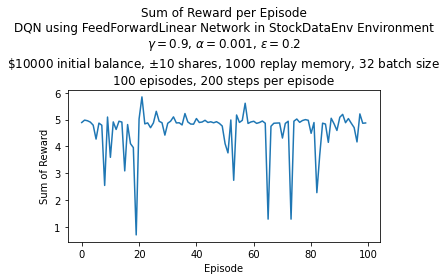

In [14]:
max_episodes = 100 # 1000 # Upper-limit on number of possible episodes.
max_steps = 200
render = False
render_mode = 'csv'

# Train the agent 
with timecontextprint():
    rewards, found_soln = train_DQN(
        agent, 
        max_episodes, 
        max_steps,
        target_update_freq, 
        render, 
        render_mode,
    )

# Plot the rewards.
plt.figure()
plt.plot(rewards)
plt.title(f"Sum of Reward per Episode\nDQN using FeedForwardLinear Network in {env_name} Environment\n$\gamma={gamma}$, $\\alpha={alpha}$, $\epsilon={epsilon}$\n\${start_balance} initial balance, $\pm${max_stock} shares, {memory_capacity} replay memory, {batch_size} batch size\n{max_episodes} episodes, {max_steps} steps per episode")
plt.xlabel('Episode')
plt.ylabel('Sum of Reward')
plt.tight_layout()
plt.show()